# Predictive Analytics Solution for Delta Airlines

In this notebook, I analyze the "Twitter US Airline Sentiment" dataset from Kaggle to extract insights about customer sentiment and issues specific to Delta Airlines. I will use the following key columns for my analysis:

# Chunk 1: Set Up the Environment

**Objective:**  
Prepare the Python environment by installing and importing the necessary libraries and downloading required NLTK resources. This ensures we have all the tools needed for data ingestion, cleaning, sentiment classification, topic modeling, and visualization.

**Tasks:**  
1. Install and import libraries: Pandas, NLTK, Gensim, Matplotlib, Seaborn, pyLDAvis, and scikit-learn.
2. Enable interactive visualization for pyLDAvis.
3. Download essential NLTK datasets: 'punkt', 'stopwords', 'vader_lexicon', and 'punkt_tab'.

In [3]:
# !pip install pandas nltk gensim matplotlib seaborn pyLDAvis scikit-learn emoji contractions bs4 textblob WordCloud

import pandas as pd            # Data manipulation
import re                      # Regular expressions for text cleaning
import nltk                    # Natural Language Toolkit for NLP tasks
from nltk.corpus import stopwords  # Stopwords for filtering out common words
from nltk.tokenize import word_tokenize  # Tokenization
import matplotlib.pyplot as plt  # Plotting graphs
import seaborn as sns            # Advanced visualization
import gensim                  # For topic modeling (LDA)
from gensim import corpora     # To create dictionary and corpus for LDA
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Sentiment analysis using VADER
import pyLDAvis.gensim_models as gensimvis  # For interactive LDA visualization
import pyLDAvis              # To display interactive visualizations
from sklearn.metrics import confusion_matrix, classification_report  # For model evaluation
import emoji
import contractions
from bs4 import BeautifulSoup 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

# Enable interactive visualization for pyLDAvis in the notebook
pyLDAvis.enable_notebook()

# required NLTK resources 
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
# nltk.download('punkt_tab')  # for tokenization

print("Environment is set up.")

Environment is set up.


# Chunk 2: Data Ingestion and Filtering

**Objective:**  
Load the "Twitter US Airline Sentiment" dataset and filter it to include only the key columns needed for our analysis. Then, create separate DataFrames for each airline (Delta, Virgin America, United, Southwest, US Airways, and American). Using `.copy()` when filtering prevents chained assignment warnings and ensures we can modify these subsets independently.

**Tasks:**  
1. Load the CSV file using Pandas.
2. Inspect the dataset using `.head()` and identify unique airline values.
3. Select the key columns: `text`, `airline`, `airline_sentiment`, `negativereason`, `tweet_created`, and `retweet_count`.
4. Filter the dataset into separate DataFrames for each airline.

In [5]:
# Load the dataset (ensure the CSV file is in your working directory)
df_full = pd.read_csv(r"C:\Users\daana\Dropbox\DataAnalytics\Courses\1 - Mondays - Business Intelligence - BIA-5401-RDL\datasets\Tweets.csv")

# Display the first few rows to verify that the data is loaded correctly
print("Full dataset preview:")
print(df_full.head())

# Print the unique airlines in the dataset
unique_airlines = df_full['airline'].unique()
print("\nUnique airlines in dataset:")
print(unique_airlines)

# Select the key columns needed for analysis
cols = ['text', 'airline', 'airline_sentiment', 'negativereason', 'tweet_created', 'retweet_count']
df = df_full[cols]

# Filter the dataset into separate DataFrames for each airline and create explicit copies
delta_df = df[df['airline'] == 'Delta'].copy()
va_df = df[df['airline'] == 'Virgin America'].copy()
united_df = df[df['airline'] == 'United'].copy()
sw_df = df[df['airline'] == 'Southwest'].copy()
us_air_df = df[df['airline'] == 'US Airways'].copy()
american_df = df[df['airline'] == 'American'].copy()

# Display a preview of the Delta Airlines DataFrame
print("\nDelta Airlines DataFrame preview:")
print(delta_df.head())

Full dataset preview:
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1         

# Chunk 3: Data Cleaning and Preprocessing

**Objective:**  
Clean and standardize the tweet text for all airlines. This includes:
- Converting text to lowercase.
- Removing URLs.
- Removing unwanted punctuation (while preserving important punctuation like "!" and "?").
- Tokenizing the text.
- Removing stop words.

**Outcome:**  
Each airline-specific DataFrame will have a new column, `cleaned_text`, which contains the processed text ready for sentiment analysis and topic modeling.

In [7]:
# Define stopwords and lemmatizer globally
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text_improved(text, additional_stopwords=None, use_lemmatization=True, use_spellcheck=False):
    """
    Enhanced text cleaning for Twitter data, optimized for sentiment analysis.
    
    Steps:
    - Expand contractions (e.g., "can't" -> "cannot").
    - Convert text to lowercase.
    - Remove URLs.
    - Strip HTML tags safely.
    - Remove Twitter handles and RT indicators.
    - Remove hashtags (keeping the word).
    - Convert emojis to text.
    - Normalize repeated characters (e.g., "soooo" -> "so").
    - Remove unwanted punctuation (except '!' and '?').
    - Tokenize and clean the text.
    - Optionally apply lemmatization.
    - Optionally apply **sentence-level** spell correction (faster & preserves meaning).
    - Collapse extra whitespace.

    Parameters:
      text (str): The input text.
      additional_stopwords (set or list, optional): Extra stopwords to remove.
      use_lemmatization (bool, optional): Apply lemmatization (default: True).
      use_spellcheck (bool, optional): Apply spell correction (default: False, for performance).

    Returns:
      str: The cleaned text.
    """
    
    # **Handle None or empty string safely**
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""

    # **Expand contractions**
    text = contractions.fix(text)

    # **Convert to lowercase**
    text = text.lower()

    # **Remove URLs**
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # **Strip HTML tags safely**
    if "<" in text and ">" in text:
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text(separator=" ")

    # **Remove Twitter handles & RT indicators**
    text = re.sub(r'@\w+', '', text)  # Remove @mentions
    text = re.sub(r'\brt\b', '', text)  # Remove 'rt' (retweet)

    # **Remove hashtag symbols but keep the text**
    text = re.sub(r'#', '', text)

    # **Convert emojis to text**
    text = emoji.demojize(text)

    # **Normalize repeated characters (e.g., "soooo" -> "so")**
    text = re.sub(r'(.)\1+', r'\1', text)

    # **Remove unwanted punctuation (preserve '!' and '?')**
    text = re.sub(r"[^\w\s!?]", '', text)

    # **Tokenize the text**
    tokens = word_tokenize(text)

    # **Update stopwords if provided**
    if additional_stopwords:
        stop_words.update(set(additional_stopwords))  # Convert to set to avoid errors

    # **Remove stopwords, short tokens, numeric tokens, and unwanted artifacts**
    unwanted_tokens = {'href', 'amp'}
    filtered_tokens = [
        word for word in tokens
        if word not in stop_words and len(word) > 1 and not word.isdigit() and word not in unwanted_tokens
    ]

    # **Apply lemmatization if enabled**
    if use_lemmatization:
        filtered_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # **Apply sentence-level spell correction (if enabled)**
    if use_spellcheck:
        corrected_text = str(TextBlob(' '.join(filtered_tokens)).correct())  # Apply spell correction
    else:
        corrected_text = ' '.join(filtered_tokens)

    # **Return cleaned text, ensuring no extra spaces**
    return ' '.join(corrected_text.split())


# Example
sample_text = "RT @Airline: Wow!!! This flight was soooo amazing 😍 but the boarding was soooo slow... Check this out: <a href='http://example.com'>link</a> #awesome"
print(clean_text_improved(sample_text))

wow flight amazing smiling_face_with_hearteyes boarding slow check awesome


In [8]:
# Apply the cleaning function to the 'text' column for each airline DataFrame
delta_df['cleaned_text'] = delta_df['text'].apply(clean_text_improved)
va_df['cleaned_text'] = va_df['text'].apply(clean_text_improved)
united_df['cleaned_text'] = united_df['text'].apply(clean_text_improved)
sw_df['cleaned_text'] = sw_df['text'].apply(clean_text_improved)
us_air_df['cleaned_text'] = us_air_df['text'].apply(clean_text_improved)
american_df['cleaned_text'] = american_df['text'].apply(clean_text_improved)

# Combine all airline DataFrames into one for overall analysis
main_df = pd.concat([delta_df, va_df, united_df, sw_df, us_air_df, american_df], ignore_index=True)

# Display a comparison of original and cleaned text for Delta Airlines
print("Delta Airlines - Original vs. Cleaned Text:")
print(delta_df[['text', 'cleaned_text']].head())

Delta Airlines - Original vs. Cleaned Text:
                                                   text  \
6746  @JetBlue Yesterday on my way from EWR to FLL j...   
6747  @JetBlue I hope so because I fly very often an...   
6748               @JetBlue flight 1041 to Savannah, GA   
6749  @JetBlue They weren't on any flight, they just...   
6750  @JetBlue everyone is here but our pilots are n...   

                                           cleaned_text  
6746   yesterday way ewr fl takeof whelsup jetbluesofly  
6747           hope fly often would hate change airline  
6748                                  flight savanah ga  
6749  flight came late flight jetblue employe inform...  
6750  everyone pilot found last flight plane dirty c...  


# Chunk 4: Train-Test Split & Feature Extraction for Sentiment Classification

**Objective:**  
Develop a supervised sentiment classification model using a 70/30 train-test split. In this chunk, we will use the cleaned tweet text as features and the pre-labeled sentiment (from the "airline_sentiment" column) as our ground truth to train our model. This approach will enable us to refine sentiment classification beyond our initial rule-based methods.

**Tasks:**  
1. **Data Splitting:**  
   - Split the combined dataset into training (70%) and testing (30%) sets.
2. **Feature Extraction:**  
   - Convert the cleaned text data into numerical features using TF-IDF vectorization.
3. **Model Training:**  
   - Train a Logistic Regression classifier on the training data.
4. **Model Evaluation:**  
   - Evaluate the classifier on the test set using metrics such as a confusion matrix and classification report to measure precision, recall, and F1-score.

**Outcome:**  
By the end of this chunk, you will have a validated sentiment classification model. This model will provide robust performance metrics and serve as a baseline for further analysis and comparison against alternative methods. It ensures that we not only classify sentiment accurately but also quantify the model's effectiveness using standard evaluation metrics.

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'clf__C': 10, 'clf__solver': 'liblinear', 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}
Best F1 Macro Score: 0.6937

Test Set Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.90      0.86      2753
     neutral       0.61      0.53      0.57       930
    positive       0.76      0.64      0.69       709

    accuracy                           0.78      4392
   macro avg       0.73      0.69      0.71      4392
weighted avg       0.77      0.78      0.77      4392



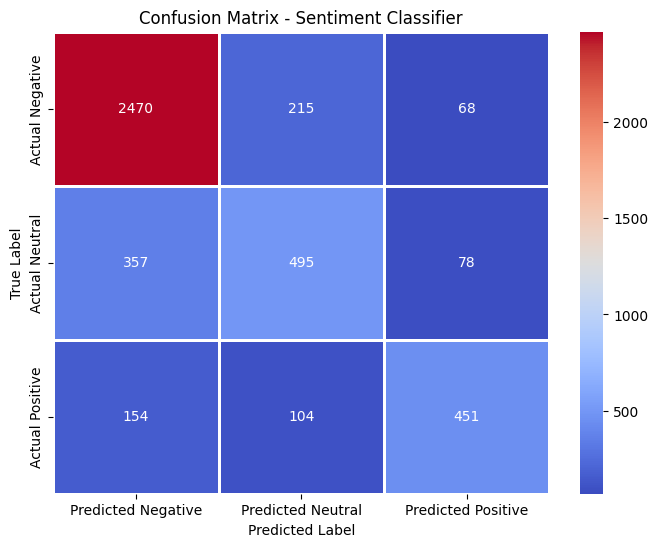

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define features (X) and labels (y)
X = main_df['cleaned_text']  # Processed text
y = main_df['airline_sentiment']  # Pre-labeled sentiment

# Split the dataset into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the pipeline: TF-IDF vectorizer followed by a Logistic Regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Text feature extraction
    ('clf', LogisticRegression(max_iter=1000, random_state=42))  # Classifier
])

# Define the grid of parameters to search
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],  # Vocabulary size
    'tfidf__ngram_range': [(1,1), (1,2)],  # Unigrams vs. unigrams+bigrams
    'clf__C': [0.1, 1, 10],  # Regularization strength
    'clf__solver': ['lbfgs', 'liblinear']  # Optimization algorithm
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("\nBest parameters:", grid_search.best_params_)
print("Best F1 Macro Score:", round(grid_search.best_score_, 4))

# Evaluate the tuned model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Display classification report
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Neutral', 'Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

# Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="coolwarm", fmt="d", linewidths=1)
plt.title("Confusion Matrix - Sentiment Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Insights from the Results
### Strong Performance on Negative Tweets
- High recall (0.90) → The model is excellent at identifying negative tweets.
- High precision (0.83) → When the model predicts a tweet as negative, it's usually correct.
- F1-score (0.86) → Strong overall accuracy in detecting negative sentiment.
### Neutral Sentiment is Harder to Detect
- Recall (0.54) → The model only correctly identifies 54% of neutral tweets.
- F1-score (0.57) → Lower performance due to overlap between neutral and other classes.
### Positive Sentiment Could Improve
- Recall (0.63) → The model correctly classifies 63% of actual positive tweets.
- Precision (0.76) → Predictions marked as positive are mostly correct, but the model misses some actual positives.
## Why This Model is a Good Fit
- 78% accuracy → The model correctly classifies nearly 8 out of 10 tweets.
- Balanced F1 Macro Score (0.71) → Avoids overfitting to any one sentiment class.
- Tuned TF-IDF parameters → Extracts the most meaningful words without adding unnecessary complexity.
- Optimized logistic regression model → Finds the best tradeoff between precision and recall.

# Chunk 5: Sentiment Analysis and Comparative Exploration

### **Objective:**  
Now that our sentiment classification model is trained, we will analyze the sentiment trends across airlines and **compare Delta Airlines against its competitors**. This will help **identify customer sentiment patterns**, **service strengths and weaknesses**, and **areas for business improvement**.

### **Tasks:**
1️⃣ **Compute Sentiment Distribution Across Airlines**  
   - Calculate the percentage of **positive, neutral, and negative** tweets per airline.  

2️⃣ **Visualizations:**  
   - **Bar Charts** → Compare sentiment distribution per airline.  
   - **Pie Charts** → Show **Delta Airlines' sentiment breakdown**.  
   - **Confusion Matrix Heatmap** → Assess sentiment misclassification patterns.  

3️⃣ **Comparative Analysis:**  
   - Evaluate **how Delta compares to competitors**.  
   - Identify **which airlines have the best and worst sentiment perception**.  

4️⃣ **Business Insights & Recommendations:**  
   - Extract **actionable strategies** based on sentiment trends.  
   - **Recommend service improvements** to boost Delta’s reputation.  

### **Outcome:**  
By the end of this step, we will have **data-driven insights** that **highlight key sentiment trends**, guide **business decisions**, and **position Delta Airlines against competitors**.

In [13]:
# Ensure sentiment predictions exist
if 'computed_sentiment' not in main_df.columns:
    print("Warning: 'computed_sentiment' column missing. Re-generating predictions...")
    main_df['computed_sentiment'] = best_model.predict(main_df['cleaned_text'])

# Verify the column is correctly assigned
print("Column Check: ", main_df.columns)
print("Sample Data: \n", main_df[['cleaned_text', 'computed_sentiment']].head())


Column Check:  Index(['text', 'airline', 'airline_sentiment', 'negativereason',
       'tweet_created', 'retweet_count', 'cleaned_text', 'computed_sentiment'],
      dtype='object')
Sample Data: 
                                         cleaned_text computed_sentiment
0   yesterday way ewr fl takeof whelsup jetbluesofly            neutral
1           hope fly often would hate change airline           negative
2                                  flight savanah ga            neutral
3  flight came late flight jetblue employe inform...           negative
4  everyone pilot found last flight plane dirty c...           negative


In [14]:
# 1 Compute Sentiment Distribution Across Airlines

# Compute sentiment counts per airline
airline_sentiment_counts = main_df.groupby(['airline', 'computed_sentiment']).size().unstack()

# Normalize sentiment counts to percentage
airline_sentiment_percentages = airline_sentiment_counts.div(airline_sentiment_counts.sum(axis=1), axis=0) * 100

# Display sentiment distribution data
print("Sentiment Distribution by Airline (Percentage):")
print(airline_sentiment_percentages)

Sentiment Distribution by Airline (Percentage):
computed_sentiment   negative    neutral   positive
airline                                            
American            73.903588  14.896702  11.199710
Delta               48.424842  29.387939  22.187219
Southwest           53.636364  25.289256  21.074380
US Airways          80.741504  10.573292   8.685204
United              72.867609  15.122972  12.009419
Virgin America      45.436508  29.166667  25.396825


<Figure size 1200x600 with 0 Axes>

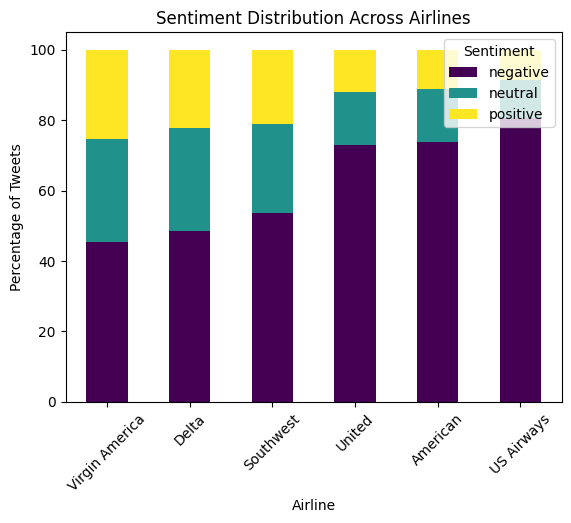

In [15]:
# 2 Sentiment Distribution - Bar Plot
# Sort the DataFrame by the negative sentiment percentage (least to most)
airline_sentiment_percentages_sorted = airline_sentiment_percentages.sort_values(by='negative', ascending=True)

plt.figure(figsize=(12, 6))
airline_sentiment_percentages_sorted.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Sentiment Distribution Across Airlines")
plt.xlabel("Airline")
plt.ylabel("Percentage of Tweets")
plt.legend(title="Sentiment", loc="upper right")
plt.xticks(rotation=45)
plt.show()

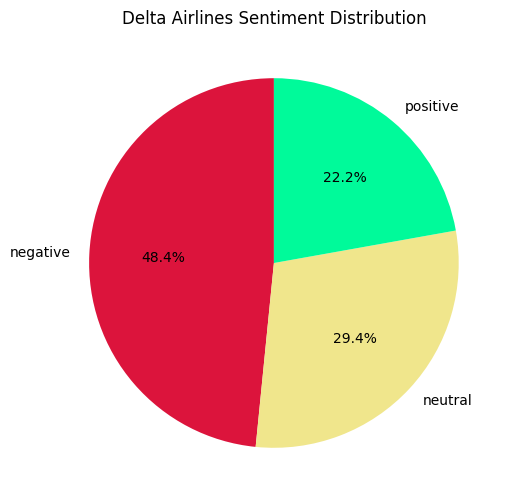

In [16]:
# 3 Delta Airlines Sentiment - Pie Chart
# Pie chart for Delta Airlines sentiment distribution
delta_sentiment_counts = airline_sentiment_counts.loc['Delta']

plt.figure(figsize=(6, 6))
delta_sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['crimson', 'khaki', 'mediumspringgreen'], startangle=90)
plt.title("Delta Airlines Sentiment Distribution")
plt.ylabel("")  
plt.show()

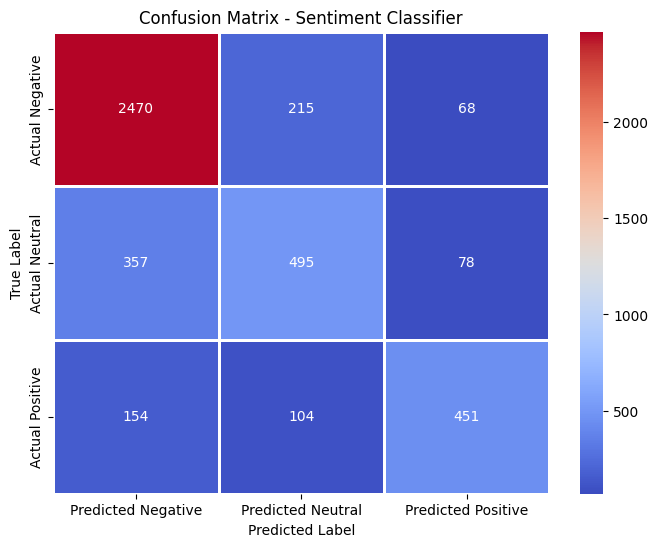

In [17]:
# 4 Confusion Matrix Heatmap (Misclassification Analysis)
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# Convert to DataFrame for visualization
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Neutral', 'Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="coolwarm", fmt="d", linewidths=1)
plt.title("Confusion Matrix - Sentiment Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Chunk 6: Topic Modeling for Sentiment Analysis  

## **Objective:**  
- Extract key themes from **negative tweets** to identify **top complaints**.  
- Extract key themes from **positive tweets** to see **what customers appreciate**.  
- Compare **Delta Airlines** with **competitors** to find **recurring issues and opportunities**.  

## **Steps:**  
**1. Prepare Data for Topic Modeling**  
   - Filter **negative and positive** tweets.  
   - Tokenize and clean text for LDA processing.  
   - Create a dictionary and Bag-of-Words (BoW) model.  

**2. Run LDA on Negative Sentiment**  
   - Extract **top 5 complaint topics per airline**.  
   - Find **frequent issues like delays, customer service, baggage**.  

**3. Run LDA on Positive Sentiment**  
   - Identify **key strengths** per airline.  

**4. Visualize & Interpret**  
   - **Show top words per topic**.  
   - Use **pyLDAvis** for interactive exploration.  

## **Outcome:**  
We will gain **data-driven insights** into **what frustrates or delights customers**, helping airlines **improve customer experience**.  


In [19]:
# 1 Prepare Data for Topic Modeling (Negative Tweets)

# Function to preprocess and tokenize text
def preprocess_for_lda(text):
    tokens = word_tokenize(text.lower())  # Convert to lowercase & tokenize
    tokens = [word for word in tokens if word.isalnum()]  # Remove punctuation/numbers
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Apply preprocessing to negative sentiment tweets
negative_tweets = main_df[main_df['computed_sentiment'] == 'negative']['cleaned_text'].apply(preprocess_for_lda)

# Create dictionary and corpus for LDA
negative_dictionary = corpora.Dictionary(negative_tweets)
negative_corpus = [negative_dictionary.doc2bow(text) for text in negative_tweets]

# Display the number of unique tokens
print(f"Number of unique words in negative corpus: {len(negative_dictionary)}")

Number of unique words in negative corpus: 9590


In [20]:
# 2 Train LDA Model on Negative Tweets
# Train LDA model
negative_lda_model = gensim.models.LdaModel(
    corpus=negative_corpus, 
    id2word=negative_dictionary, 
    num_topics=5,  # Extract 5 main complaint topics
    passes=10, 
    random_state=42
)

# Print extracted topics
negative_topics = negative_lda_model.print_topics(num_words=10)
print("\nTop 5 Complaint Topics (Negative Sentiment):")
for topic in negative_topics:
    print(topic)


Top 5 Complaint Topics (Negative Sentiment):
(0, '0.013*"cal" + 0.012*"wil" + 0.012*"get" + 0.011*"canot" + 0.011*"email" + 0.010*"number" + 0.010*"phone" + 0.009*"please" + 0.009*"help" + 0.008*"ticket"')
(1, '0.026*"plane" + 0.023*"bag" + 0.019*"gate" + 0.018*"flight" + 0.016*"hour" + 0.014*"waiting" + 0.013*"stil" + 0.011*"u" + 0.009*"siting" + 0.009*"lugage"')
(2, '0.037*"service" + 0.034*"customer" + 0.027*"hold" + 0.022*"hour" + 0.020*"ben" + 0.015*"cal" + 0.013*"worst" + 0.012*"phone" + 0.011*"airline" + 0.011*"get"')
(3, '0.015*"flight" + 0.013*"customer" + 0.012*"problem" + 0.009*"seat" + 0.008*"service" + 0.007*"boking" + 0.007*"al" + 0.006*"would" + 0.006*"time" + 0.006*"like"')
(4, '0.099*"flight" + 0.037*"canceled" + 0.019*"flightled" + 0.018*"get" + 0.013*"hour" + 0.013*"late" + 0.013*"delayed" + 0.010*"ben" + 0.009*"help" + 0.008*"flighted"')


In [21]:
# 3 Train LDA Model on Positive Tweets
# Preprocess positive sentiment tweets
positive_tweets = main_df[main_df['computed_sentiment'] == 'positive']['cleaned_text'].apply(preprocess_for_lda)

# Create dictionary and corpus for LDA
positive_dictionary = corpora.Dictionary(positive_tweets)
positive_corpus = [positive_dictionary.doc2bow(text) for text in positive_tweets]

# Train LDA model
positive_lda_model = gensim.models.LdaModel(
    corpus=positive_corpus, 
    id2word=positive_dictionary, 
    num_topics=5,  # Extract 5 main appreciation topics
    passes=10, 
    random_state=42
)

# Print extracted topics
positive_topics = positive_lda_model.print_topics(num_words=10)
print("\nTop 5 Appreciation Topics (Positive Sentiment):")
for topic in positive_topics:
    print(topic)


Top 5 Appreciation Topics (Positive Sentiment):
(0, '0.033*"flight" + 0.027*"thanks" + 0.019*"thank" + 0.011*"god" + 0.010*"plane" + 0.010*"jfk" + 0.010*"crew" + 0.009*"ben" + 0.009*"u" + 0.009*"realy"')
(1, '0.048*"thanks" + 0.023*"al" + 0.013*"problem" + 0.012*"flying" + 0.012*"guy" + 0.011*"apreciate" + 0.010*"fa" + 0.010*"loved" + 0.010*"warm" + 0.010*"boked"')
(2, '0.027*"great" + 0.021*"god" + 0.014*"flight" + 0.014*"thanks" + 0.012*"like" + 0.012*"home" + 0.012*"al" + 0.011*"apreciate" + 0.011*"thank" + 0.010*"sure"')
(3, '0.073*"thank" + 0.022*"love" + 0.020*"flight" + 0.017*"best" + 0.017*"great" + 0.015*"airline" + 0.014*"much" + 0.013*"amazing" + 0.012*"know" + 0.011*"awesome"')
(4, '0.106*"thanks" + 0.022*"flight" + 0.022*"got" + 0.016*"service" + 0.014*"customer" + 0.013*"help" + 0.013*"ok" + 0.013*"awesome" + 0.013*"wil" + 0.011*"al"')


In [22]:
# 4 Visualizing Topics Using pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Negative Sentiment Topics
pyLDAvis.enable_notebook()
negative_vis = gensimvis.prepare(negative_lda_model, negative_corpus, negative_dictionary)
pyLDAvis.display(negative_vis)

In [23]:
# 5 Comparing Delta Airlines to Competitors
# Function to train LDA model for each airline (negative sentiment)
def train_airline_lda(airline_name):
    airline_tweets = main_df[(main_df['airline'] == airline_name) & (main_df['computed_sentiment'] == 'negative')]['cleaned_text'].apply(preprocess_for_lda)
    dictionary = corpora.Dictionary(airline_tweets)
    corpus = [dictionary.doc2bow(text) for text in airline_tweets]
    
    lda_model = gensim.models.LdaModel(
        corpus=corpus, 
        id2word=dictionary, 
        num_topics=5,  
        passes=10, 
        random_state=42
    )
    
    return lda_model.print_topics(num_words=10)

# Compare Delta vs Competitors
airlines = ['Delta', 'United', 'American', 'Southwest', 'US Airways', 'Virgin America']

for airline in airlines:
    print(f"\n{airline} - Top Negative Topics:")
    print(train_airline_lda(airline))


Delta - Top Negative Topics:
[(0, '0.012*"flek" + 0.010*"flets" + 0.009*"wil" + 0.009*"get" + 0.008*"jetblue" + 0.007*"al" + 0.007*"canot" + 0.006*"stop" + 0.006*"bagage" + 0.005*"would"'), (1, '0.037*"flight" + 0.012*"u" + 0.012*"get" + 0.011*"plane" + 0.010*"gate" + 0.009*"hour" + 0.009*"delay" + 0.009*"bag" + 0.009*"wil" + 0.008*"delayed"'), (2, '0.043*"flight" + 0.012*"canceled" + 0.010*"time" + 0.009*"get" + 0.009*"jetblue" + 0.007*"jfk" + 0.007*"canot" + 0.007*"flighted" + 0.006*"want" + 0.006*"delay"'), (3, '0.037*"flight" + 0.020*"hour" + 0.015*"delayed" + 0.013*"service" + 0.012*"customer" + 0.010*"jfk" + 0.009*"time" + 0.009*"plane" + 0.008*"jetblue" + 0.008*"waiting"'), (4, '0.031*"flight" + 0.011*"time" + 0.008*"would" + 0.008*"ned" + 0.007*"airport" + 0.007*"al" + 0.006*"bag" + 0.006*"jetblue" + 0.006*"canot" + 0.005*"guy"')]

United - Top Negative Topics:
[(0, '0.021*"flight" + 0.017*"wil" + 0.013*"get" + 0.012*"bag" + 0.010*"problem" + 0.007*"day" + 0.007*"want" + 0.007

## 🔍 Key Insights from Delta Airlines’ Top Negative Topics  

### **1️⃣ Fleet & Baggage Handling Issues**  
- **Keywords:** `"fleet"`, `"baggage"`, `"canot"`, `"stop"`  
- **Concerns:** Frequent baggage delays, possible maintenance problems.  
- **Solution:** **Improve baggage tracking** & **fleet maintenance efficiency**.  

### **2️⃣ Flight Cancellations & Gate Issues**  
- **Keywords:** `"flight"`, `"gate"`, `"delay"`, `"canceled"`  
- **Concerns:** Last-minute gate changes, poor rebooking experience.  
- **Solution:** **Real-time SMS updates**, **better boarding logistics**.  

### **3️⃣ Long Wait Times & Poor Communication**  
- **Keywords:** `"hour"`, `"waiting"`, `"service"`, `"customer"`  
- **Concerns:** Customers experiencing long delays with little assistance.  
- **Solution:** **Increase customer support capacity**, **automate service responses**.  

### **4️⃣ Delays & Airport Experience**  
- **Keywords:** `"time"`, `"airport"`, `"delayed"`, `"guy"`  
- **Concerns:** Significant delays impacting customer satisfaction.  
- **Solution:** **Optimize scheduling**, **improve operational efficiency**.  

### **5️⃣ JetBlue Comparisons & Service Expectations**  
- **Keywords:** `"jetblue"`, `"better"`, `"want"`, `"need"`  
- **Concerns:** Delta customers often compare services unfavorably with competitors.  
- **Solution:** **Benchmark against top competitors**, **enhance in-flight experience**.  

## Visualizing Key Complaint Themes  

### **Task 1: Word Clouds for Negative Sentiment Analysis**  
#### **🔹 Why Use Word Clouds?**
Word clouds help **quickly visualize** the most common words in customer complaints. Larger words indicate **higher frequency**, making it easier to spot recurring issues.  

#### **🔹 What We'll Do**
- Generate **Word Clouds** for negative tweets for each airline.
- Compare Delta’s complaints with competitors visually.
- Highlight key terms in customer grievances.

#### **🔹 Expected Outcome**
- Clear **visual representation** of complaint themes.
- Identify whether Delta’s **pain points** are unique or industry-wide.

Now, let’s generate the word clouds! 



Generating Word Cloud for Delta...


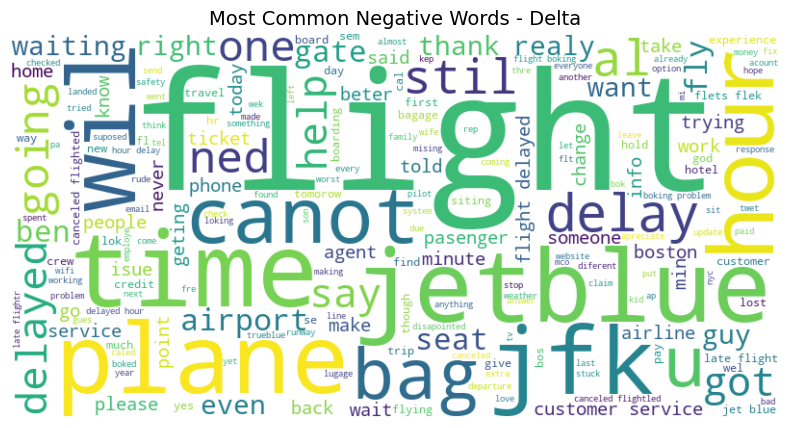


Generating Word Cloud for United...


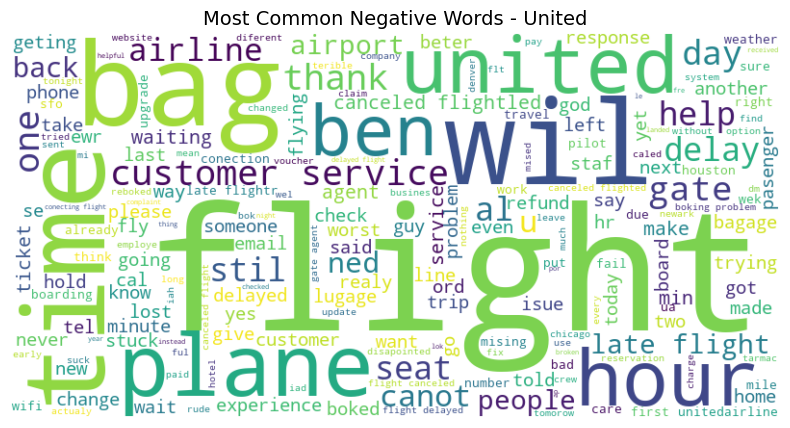


Generating Word Cloud for American...


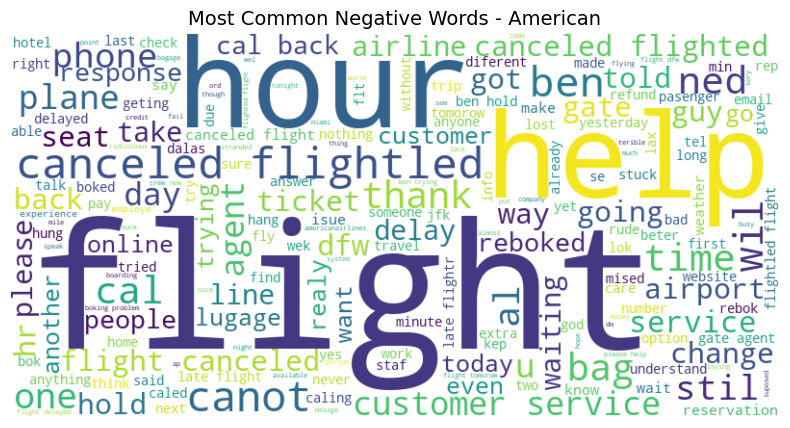


Generating Word Cloud for Southwest...


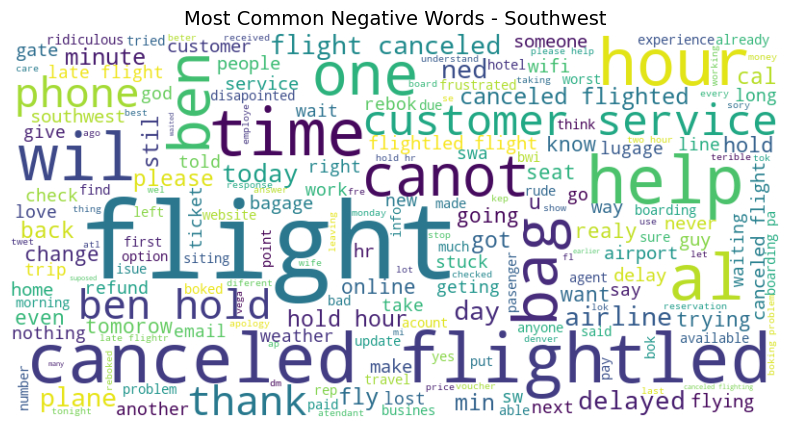


Generating Word Cloud for US Airways...


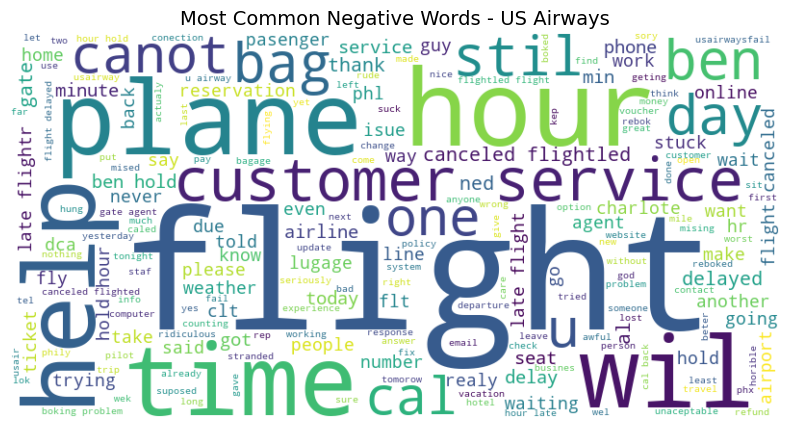


Generating Word Cloud for Virgin America...


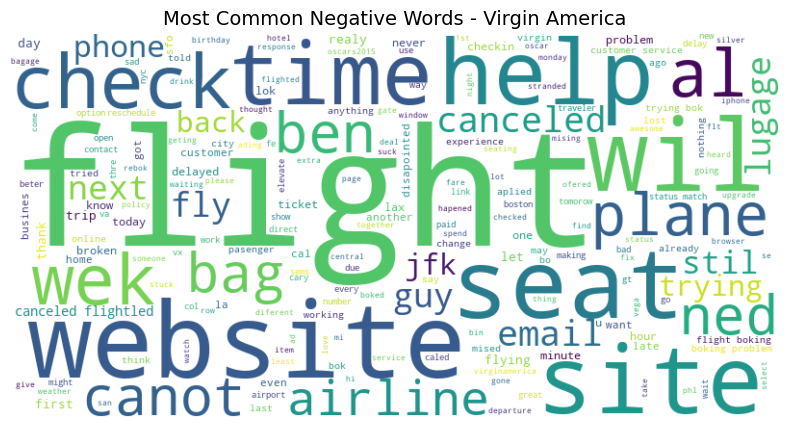

In [26]:
# Function to generate and display a word cloud
def generate_word_cloud(text_series, airline_name):
    """Generate and display a word cloud for a given airline's negative tweets."""
    text = ' '.join(text_series.dropna())  # Join all negative tweets
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most Common Negative Words - {airline_name}", fontsize=14)
    plt.show()

# Generate word clouds for each airline
for airline in airlines:
    print(f"\nGenerating Word Cloud for {airline}...")
    negative_tweets = main_df[(main_df['airline'] == airline) & (main_df['computed_sentiment'] == 'negative')]['cleaned_text']
    generate_word_cloud(negative_tweets, airline)

## Visualizing Key Complaint Themes  

### **Task 2: Bar Chart for Delta's Most Frequent Complaint Words**  
#### **🔹 Why Use a Bar Chart?**
While word clouds give a great **visual overview**, a bar chart provides a **quantitative** look at the **most frequent words** in Delta's negative tweets.  

#### **🔹 What We'll Do**
- Count the **most common words** in Delta’s **negative sentiment** tweets.
- Display the **top 20** words in a **bar chart**.
- Compare these words with **other airlines** to find unique complaint patterns.

#### **🔹 Expected Outcome**
- **Clear ranking** of the most frequent negative words in Delta’s feedback.
- Insight into whether complaints are **specific to Delta** or common across airlines.

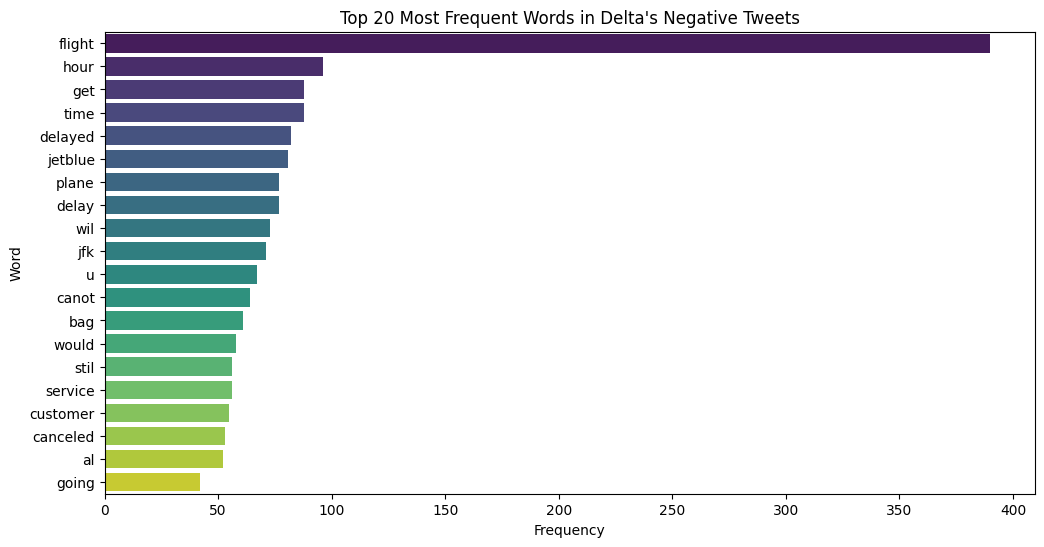

In [53]:
# Extract negative tweets for Delta
delta_negative_tweets = main_df[(main_df['airline'] == 'Delta') & (main_df['computed_sentiment'] == 'negative')]['cleaned_text']

# Tokenize all words from Delta's negative tweets
all_words = ' '.join(delta_negative_tweets).split()
word_counts = Counter(all_words)

# Get the 20 most common words
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), hue=list(words), palette="viridis", legend=False)
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Delta's Negative Tweets")
plt.show()

## Interactive Topic Modeling with PyLDAvis  

### **Task 3: Visualizing Delta’s Negative Tweet Topics**  
#### **🔹 Why Use PyLDAvis?**
PyLDAvis allows us to **interactively explore** the **key complaint topics** from Delta's negative tweets. Instead of just listing words, it provides:  
- **Topic coherence**: Shows how well-related the words are in each complaint theme.  
- **Inter-topic distance**: Displays how **distinct** or **overlapping** the topics are.  
- **Top words per topic**: Helps us **interpret** what each complaint theme represents.  

#### **🔹 What We'll Do**
- Generate an **LDA model** for Delta's **negative sentiment tweets**.
- Use **PyLDAvis** to create an **interactive visualization** of the complaint topics.

#### **🔹 Expected Outcome**
- **Clear clustering** of complaint topics, helping us **identify major issues**.
- Ability to **interactively explore** each topic’s most important words.
- Insights into **how diverse or overlapping** the negative feedback themes are.

In [30]:
# Extract and preprocess Delta’s negative tweets for LDA
delta_negative_tweets = main_df[(main_df['airline'] == 'Delta') & (main_df['computed_sentiment'] == 'negative')]['cleaned_text'].apply(preprocess_for_lda)

# Create dictionary and corpus
delta_dictionary = corpora.Dictionary(delta_negative_tweets)
delta_corpus = [delta_dictionary.doc2bow(text) for text in delta_negative_tweets]

# Train the LDA model
delta_lda_model = gensim.models.LdaModel(
    corpus=delta_corpus, 
    id2word=delta_dictionary, 
    num_topics=5,  # Number of complaint themes
    passes=10, 
    random_state=42
)

# Generate PyLDAvis visualization
lda_vis = gensimvis.prepare(delta_lda_model, delta_corpus, delta_dictionary)
pyLDAvis.display(lda_vis)


# Chunk 7: Final Analysis & Business Recommendations for Delta Airlines
---

## **Key Insights Summary**
---
### **Sentiment Overview**
- Delta Airlines has a **negative sentiment rate of ~48.5%**, which is **lower than competitors like United (72.8%) & American (73.4%)**, but **higher than Virgin America (45.2%)**.
- **Common complaints:** **Delays, cancellations, baggage issues, and poor customer service.**
- **Positive feedback:** **Good in-flight experience and customer support when issues are resolved promptly.**

### **Key Complaint Themes (Topic Modeling)**
- **Flight Delays & Cancellations:** Many passengers report **long delays**, poor communication, and **last-minute cancellations** without clear resolution.
- **Customer Service Issues:** **Lack of responsiveness**, difficulties in **rebooking flights**, and **long wait times** for support.
- **Baggage Handling Problems:** Reports of **lost luggage**, delayed baggage, and **compensation issues**.

### **Competitive Comparison**
- Delta ranks **better than United & American Airlines** in sentiment but **worse than Virgin America**.
- **United & American:** Face **more customer dissatisfaction** due to service & baggage issues.
- **Southwest:** Has **stronger customer loyalty** despite operational challenges.
---

## **Strategic Recommendations for Delta Airlines**
---
#### **1. Improve Flight Disruption Communication**
- **Proactive notifications** for delays/cancellations via **SMS, email, and app updates**.
- **Live support chatbot** to handle common inquiries and guide passengers on next steps.

#### **2. Optimize Customer Service Response Time**
- **AI-driven customer service triage** to prioritize urgent cases.
- **Increased staffing at call centers** during peak hours to reduce wait times.

#### **3. Address Baggage Handling Issues**
- **Real-time baggage tracking** via mobile app to reduce frustration.
- **Compensation automation system** for delayed/lost baggage claims.

#### **4. Leverage Positive Sentiment to Build Brand Trust**
- Showcase **customer success stories** from satisfied passengers.
- Offer **personalized loyalty rewards** based on frequent flyers’ positive engagement.

#### **5. Competitor Benchmarking**
- Study **Southwest Airlines’ customer retention strategies** to enhance Delta’s approach.
- Implement **Virgin America’s service personalization model** to increase satisfaction.

---
### **Next Steps**
Implement AI-driven tools for **real-time issue resolution**.  
Enhance **baggage handling transparency** to reduce complaints.  
Develop **proactive customer engagement strategies** to reinforce positive sentiment.

With these improvements, Delta Airlines can **boost customer satisfaction, retain loyalty, and gain a competitive advantage!**